In [100]:
import pandas as pd
import numpy as np
import os
import pysam
import pickle as pkl
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from matplotlib import cm
from matplotlib.lines import Line2D
import seaborn as sns
from Bio import SeqIO
from scipy import stats
from sklearn.cluster import DBSCAN
from progressbar import ProgressBar
from statsmodels.stats.multitest import multipletests
from roman import toRoman
import itertools
from collections import Counter
import networkx as nx
import random

In [2]:
sns.set(style='ticks', font='DejaVu Sans')

# Import metadata

In [17]:
#import tables of strain identities and cross parents
nano_strains = pd.read_csv('/mnt/HDD3/lrma/script/nano_strains.csv', index_col=0)
cross_parents = pd.read_csv('/mnt/HDD3/lrma/private_variants/cross_parents.txt', sep=';', header=None, index_col=0).squeeze()
parent_strains = pd.read_csv('/mnt/HDD1/paradoxus_nanopore/MA_parents/script/batch_nanopore.csv', header=None, index_col=0)

In [4]:
cross_alias = {'VL3':'CC1',
              'VL4':'CC2',
              'VL5':'CC3',
              'VL1':'BB1',
              'VL2':'BB2',
              'L1':'BC1',
              'L2':'BC2',
              'M1':'BA1',
              'M2':'BA2',
              'H1':'BSc1',
              'H2':'BSc2'}
cross_order = {j:i for i,j in enumerate(['CC1', 'CC2', 'CC3', 'BB1', 'BB2', 'BC1', 'BC2', 'BA1', 'BA2', 'BSc1', 'BSc2'])}

In [5]:
ns_subg = pd.read_csv('/mnt/HDD3/lrma/script/ns_subg.csv', index_col=0)
ns_subg['cross'] = ns_subg['cross'].replace(cross_alias)
ns_subg['group'] = ns_subg['subg'].replace({'MSH-604':'B',
                                           'UWOPS-91-202':'B',
                                           'LL2012_021':'B',
                                           'LL2012_028':'B',
                                           'LL2011_004':'C',
                                           'LL2011_009':'C',
                                           'MSH-587-1':'C',
                                           'LL2011_012':'C',
                                           'LL2011_001':'C',
                                           'YPS644':'A',
                                           'YPS744':'A',
                                           'LL2013_040':'Sc',
                                           'LL2013_054':'Sc'})
ns_subg['shared_subg'] = ns_subg['subg'].replace({'MSH-604':0,
                                           'UWOPS-91-202':0,
                                           'LL2012_021':2,
                                           'LL2012_028':2,
                                           'LL2011_004':1,
                                           'LL2011_009':1,
                                           'MSH-587-1':2,
                                           'LL2011_012':2,
                                           'LL2011_001':2,
                                           'YPS644':2,
                                           'YPS744':2,
                                           'LL2013_040':2,
                                           'LL2013_054':2})

In [6]:
ty_colors = {'Ty1p':cm.tab10(0),
             'TY1':cm.tab10(0),
             'TY2':cm.tab10(1),
             'Ty3p':cm.tab10(2),
             'TY3':cm.tab10(2),
             'Tsu4':cm.tab10(3),
             'TY4':cm.tab10(4),
             'TY5':cm.tab10(5),
             'Ty5p':cm.tab10(5)}

In [7]:
tig_off = {}
for r in set(ns_subg['subg']):
    path = f'/home/mathieu/paradoxus_nanopore/MA_parents/assemblies/{r}.chromosomes.rdna.fasta'
    tig_off[r] = pd.concat([pd.Series([seq.id, len(seq.seq)]) for seq in SeqIO.parse(path, 'fasta')], axis=1).T
    tig_off[r].index = tig_off[r][0].values
    tig_off[r][2] = np.concatenate([np.array([0]), np.cumsum(tig_off[r][1].values)[:-1]])
    tig_off[r][3] = tig_off[r][1] + tig_off[r][2]
    tig_off[r]['color'] = np.tile([0,1], 10)[:tig_off[r].shape[0]]

In [ ]:
gff = pd.read_csv('/mnt/HDD3/lrma/RepeatMasker/A17.MSH-604/A17.MSH-604.chroder.qry.fasta.out.gff', sep='\t', comment='#', header=None)
gff['fam'] = gff[8].apply(lambda x: x.split(' ')[1].strip('"').split(':')[1])
# subset only internal sequences
gff = gff.loc[gff['fam'].apply(lambda x: 'LTR' not in x)]
gff.head()
gff[[0,3,4]].to_csv('/mnt/HDD3/lrma/RepeatMasker/A17.MSH-604/A17.MSH-604.internal.bed', sep='\t', header=None, index=None)

In [ ]:
#optimize liftover procedure
bed = []
ll_genome = {seq.id:seq for seq in SeqIO.parse('/mnt/HDD3/lrma/medaka/A88.LL2011_004/consensus.fasta', 'fasta')}

for tig, seq in ll_genome.items():
    tig_len = len(seq.seq)
    for i in np.arange(0, tig_len-500, 500):
        bed.append(f'{tig}\t{i}\t{i+500}')

with open('/mnt/HDD3/lrma/minimap_aln/opt/A88.LL2011_004.tiled.bed', 'w') as handle:
    handle.write('\n'.join(bed))
#(base) mathieu@mathieu-MacPro:/mnt/HDD3/lrma/minimap_aln/opt$ wc -l *.bed
#  23254 A88.LL2011_004.tiled.bed
#  22801 test.asm10.lift.bed
#  22867 test.asm20.lift.bed
#  22793 test.asm5.lift.bed
#  91715 total
# asm10 seems like a good choice

# Processing RepeatMasker annotations
## Import REannotation files

In [35]:
REA = []
idx = 0
with ProgressBar(max_value=254+13) as bar:
    for s in ns_subg.loc[ns_subg['identity_filter']].index:

        rea = pd.read_csv(f'/mnt/HDD3/lrma/RepeatMasker/{s}/REannotate_output/consensus.fasta.REannotation',
                          engine='python', sep=' +', header=0)
        rea['s_subg'] = s
        rea['subg'] = ns_subg.loc[s, 'subg']
        rea['cross'] = ns_subg.loc[s, 'cross']
        REA.append(rea)
        idx += 1
        bar.update(idx)
        
    for s in parent_strains.index:

        rea = pd.read_csv(f'/mnt/HDD1/paradoxus_nanopore/MA_parents/te_annotation/{s}/REannotate_output/{s}.chromosomes.fasta.REannotation',
                          engine='python', sep=' +', header=0)
        rea['s_subg'] = np.nan
        rea['subg'] = s
        rea['cross'] = 'P'
        REA.append(rea)
        idx += 1
        bar.update(idx)

REA = pd.concat(REA).reset_index(drop=True)
REA.columns = [i.strip('\t') for i in REA.columns]

100% (267 of 267) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


## Classify as full length, truncated, or solo

In [36]:
#REA['fl'] = REA.apply(lambda x: np.all(x[['nhits1','nhitsI','nhits2']] >= 1), axis=1)
REA['fl'] = (REA['nhits1'] >= 1) & (REA['nhits2'] >= 1) & (REA['nhitsI'] >= 1)
#REA['I'] = REA.apply(lambda x: x['nhitsI'] == 1, axis=1)
REA['solo'] = np.logical_xor((REA['nhits1'] >= 1), (REA['nhits2'] >= 1)) & (REA['nhitsI'] == 0)
REA['tr'] = np.logical_xor((REA['nhits1'] >= 1), (REA['nhits2'] >= 1)) & (REA['nhitsI'] >= 1)
REA['fl_tr'] = (REA['fl']) | (REA['tr'])
REA['strand'] = REA['orient'].replace({'C':'-'})

for o, df in REA.groupby('orient'):
    if o == 'C':
        REA.loc[df.index, 'start_stranded'] = df['end']
        REA.loc[df.index, 'end_stranded'] = df['start']
    elif o == '+':
        REA.loc[df.index, 'start_stranded'] = df['start']
        REA.loc[df.index, 'end_stranded'] = df['end']
        
REA['lift'] = False

## Export in bed format for liftover

In [ ]:
for s, df in REA.groupby('s_subg'):
    df[['query','start_stranded','end_stranded']].astype({'start_stranded':int, 'end_stranded':int})\
    .to_csv(f'/mnt/HDD3/lrma/RepeatMasker/{s}/REannotate_output/{s}.bed', sep='\t', header=None, index=None)

## Transform annotation coordinates based on liftover

In [37]:
rea_grouped = REA.groupby(['query','start_stranded','end_stranded'])
bar_idx = 0
with ProgressBar(max_value=254) as bar:
    for (s,r), df in ns_subg.groupby(['s_subg','subg']):
        path = f'/mnt/HDD3/lrma/liftover/{s}.lift.bed'
        if os.path.isfile(path) and os.stat(path).st_size > 0:
            bed = pd.read_csv(path, sep='\t', header=None)
            for i in bed.index:
                Tig, Start, End, switch = bed.loc[i, [0,1,2,5]]
                if switch == '-':
                    (Start, End) = (End, Start)
                Strand = ''
                if Start < End:
                    Strand = '+'
                elif Start > End:
                    Strand = '-'
                tig, start, end = bed.loc[i, 3].split('_')[:3]
                idx = rea_grouped.get_group((tig, int(start), int(end))).index
                REA.loc[idx, 'lift'] = True
                REA.loc[idx, 'Query'] = Tig

                REA.loc[idx, 'Start'] = Start
                REA.loc[idx, 'End'] = End
                REA.loc[idx, 'Strand'] = Strand
                
            bar_idx += 1
            bar.update(bar_idx)

100% (254 of 254) |######################| Elapsed Time: 0:08:36 Time:  0:08:36


minus


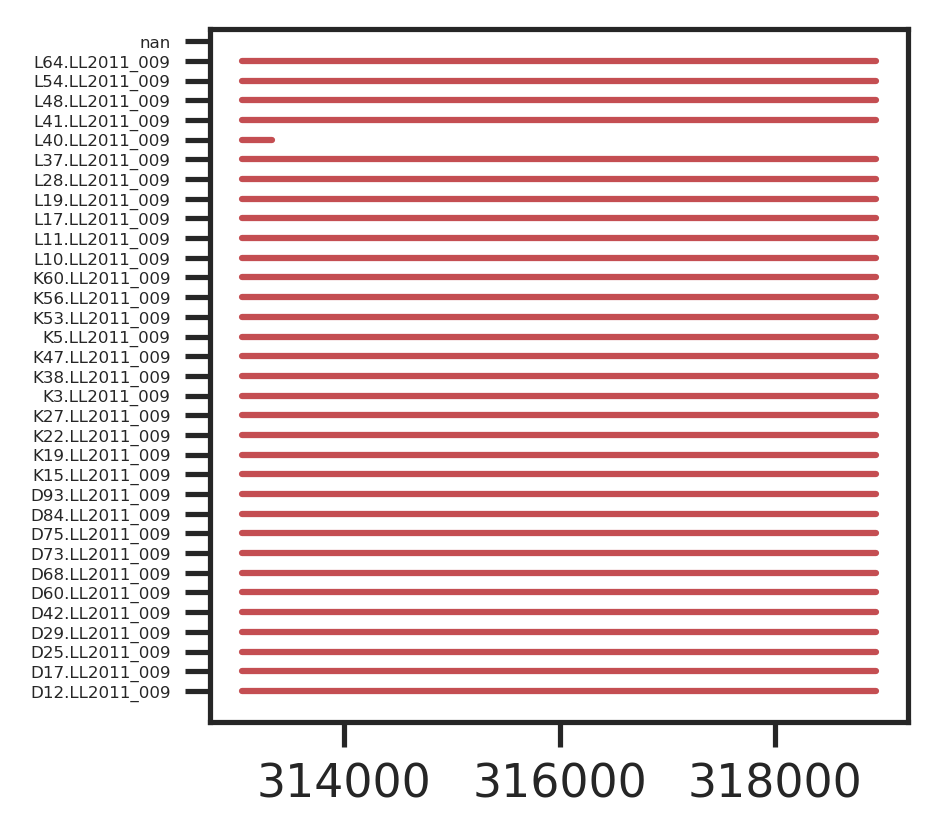

In [146]:
fig, ax = plt.subplots(figsize=[3,3])

subg, Query, Start, End = REA.loc[random.choice(sub.index), ['subg', 'Query', 'Start', 'End']]

if Start < End:
    Start = np.floor(Start*1e-3)*1e3
    End = np.ceil(End*1e-3)*1e3

    dat = REA.loc[(REA['subg']==subg)
                  & (REA['Query']==Query)
                  & (REA['Start']>Start)
                  & (REA['End']<End)].sort_values(by=['cross','s_subg'])
    print('plus')

elif Start > End:
    Start = np.ceil(Start*1e-3)*1e3
    End = np.floor(End*1e-3)*1e3

    dat = REA.loc[(REA['subg']==subg)
                  & (REA['Query']==Query)
                  & (REA['Start']<Start)
                  & (REA['End']>End)].sort_values(by=['cross','s_subg'])
    print('minus')

    
strand_color = {'+':'k', '-':'r'}
y_order = {j:i for i,j in enumerate(dat['s_subg'].unique())}

for s, df in dat.groupby('s_subg'):
    y = y_order[s]
    for i in df.index:
        fam, Start, End, Strand = df.loc[i, ['family', 'Start', 'End', 'Strand']]
        #color item
        #c = ty_colors[fam]
        c = strand_color[Strand]

        ax.plot([Start, End], [y,y], color=c)
    
ax.set_yticks(range(len(y_order)))
ax.set_yticklabels(y_order, size=4)

plt.show()
plt.close()

In [ ]:
def get_dist_cluster(coords, ):
    ((s1, e1), (s2, e2)) = coords
    if (s2-s1 < max_dist) or (np.abs(s2-e1) < max_dist) or (e2 < e1):
        return True
    else:
        return False

# Define orthogroups

In [150]:
og_idx = 0

max_dist = 500
dbscan = DBSCAN(eps=max_dist, min_samples=1)

for (subg, chrom, fam, strand), df in REA.groupby(['subg', 'Query', 'family', 'Strand']):

    if df.shape[0] > 1:
        POS = []
        IDX = []
        for i in df.index:
            start, end = df.loc[i, ['Start', 'End']]
            pos = np.nan
            if strand == '+':
                pos = np.arange(start, end, 10)
            elif strand == '-':
                pos = np.arange(end, start, 10)
            POS.append(pos)
            IDX.append(np.repeat(i, pos.shape[0]))

        POS = np.concatenate(POS)
        IDX = np.concatenate(IDX)
        
        clusters = dbscan.fit_predict(POS.reshape(-1,1))

        clusters = pd.DataFrame(np.concatenate([POS.reshape(-1,1), IDX.reshape(-1,1), clusters.reshape(-1,1)], axis=1))
        for c, df1 in clusters.groupby(2):
            if c != -1:
                cluster_name = f'og{og_idx}'
                og_idx += 1
                for i in set(df1[1]):
                    REA.loc[i, 'og'] = cluster_name
            else:
                for i in set(df1[1]):
                    cluster_name = f'og{og_idx}'
                    og_idx += 1
                    REA.loc[i, 'og'] = cluster_name
                    
    else:
        cluster_name = f'og{og_idx}'
        og_idx += 1
        REA.loc[df.index, 'og'] = cluster_name

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f140ebecf70>
Traceback (most recent call last):
  File "/home/mathieu/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/mathieu/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/mathieu/miniconda3/lib/python3.9/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/home/mathieu/miniconda3/lib/python3.9/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


## Classify orthogroups

In [162]:
for og, df in REA.groupby('og'):
    
    # find if there is a parental annotation
    og_cross = df['cross'].unique()
    if 'P' in og_cross:
        og_contains_parent = True
    else:
        og_contains_parent = False
    
    # extract the set of subgenomes; to verify if it is unique for all
    og_subg = ','.join(df.loc[~df['subg'].isna(), 'subg'].unique())
    
    # find if there is a full-length
    og_fl = True in df['fl'].unique()
    
    # extract coordinates
    pos = df[['Start', 'End']].values.flatten()
    mid = np.median(pos)
    left_bound = np.min(pos)
    right_bound = np.max(pos)
    
    REA.loc[df.index, 'og_contains_parent'] = og_contains_parent
    REA.loc[df.index, 'og_subg'] = og_subg
    REA.loc[df.index, 'og_fl'] = og_fl
    REA.loc[df.index, 'og_mid'] = mid
    REA.loc[df.index, 'og_left_bound'] = left_bound
    REA.loc[df.index, 'og_right_bound'] = right_bound

## Distribution of orthogroup size

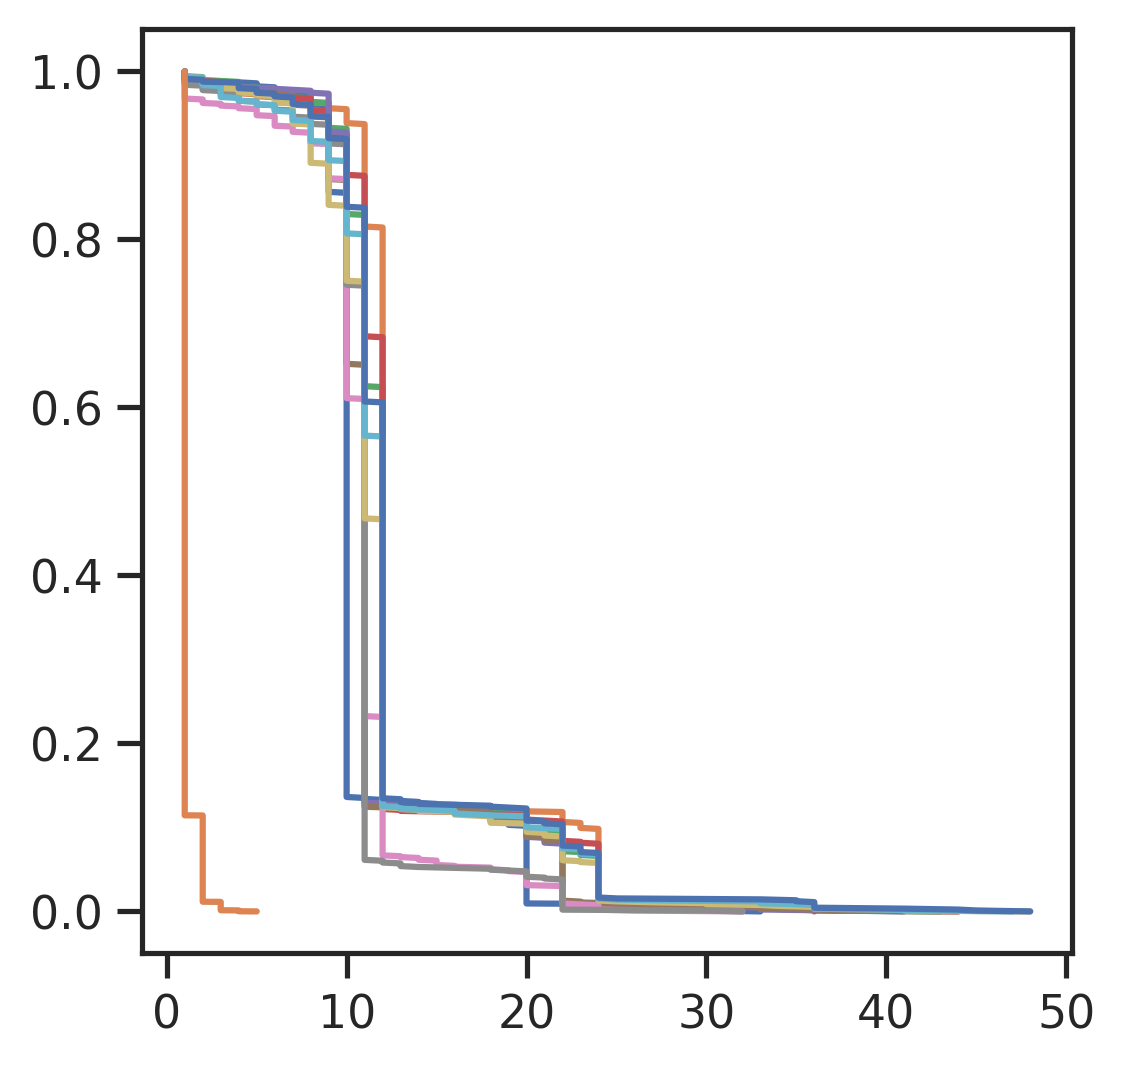

In [160]:
fig, ax = plt.subplots(figsize=[4,4])

for cross, df in REA.groupby('cross'):
    dat = df.value_counts('og')
    ax.plot(dat, np.linspace(0,1,dat.shape[0]), label=cross)
    
plt.show()
plt.close()

## get orthogroup data (deprecated)

In [ ]:
# establish midpoint values for orthogroups

og_data = []

for (subg, chrom, og), df in REA.groupby(['subg','Query','og']):
    pos = df[['Start', 'End']].values.flatten()
    mid = np.median(pos)
    left_bound = np.min(pos)
    right_bound = np.max(pos)
    
    if df['fl'].sum() > 0:
        has_fl = True
    else:
        has_fl = False
    
    og_data.append([subg, chrom, og, mid, left_bound, right_bound, has_fl])

og_data = pd.DataFrame(og_data, columns=['subg', 'chrom', 'og', 'mid', 'left_bound', 'right_bound','has_fl'])

In [ ]:
og_data.head()

In [ ]:
#export og_data
#og_data.to_csv('/mnt/HDD3/lrma/results/og_data.csv')

In [ ]:
# add og bound values to REA table
og_data_reindex = og_data.set_index('og')
for og, df in REA.groupby('og'):
    mid, left_bound, right_bound, has_fl = og_data_reindex.loc[og, ['mid', 'left_bound', 'right_bound', 'has_fl']]
    REA.loc[df.index, 'mid'] = mid
    REA.loc[df.index, 'left_bound'] = left_bound
    REA.loc[df.index, 'right_bound'] = right_bound
    REA.loc[df.index, 'has_fl'] = has_fl

## Export REA

In [163]:
REA.to_csv('/mnt/HDD3/lrma/results/REA.csv')

In [9]:
#re-import REA
REA = pd.read_csv('/mnt/HDD3/lrma/results/REA.csv', index_col=0)

/tmp/ipykernel_143434/3557277159.py:2: DtypeWarning: Columns (6,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  REA = pd.read_csv('/mnt/HDD3/lrma/results/REA.csv', index_col=0)


In [12]:
REA.value_counts(['subg', 'Query'], sort=False)

subg        Query  
LL2011_001  chrI        91
            chrII      337
            chrIII     287
            chrIV      737
            chrIX      168
                      ... 
YPS744      chrXII     410
            chrXIII    476
            chrXIV     186
            chrXV      441
            chrXVI     433
Length: 208, dtype: int64

In [ ]:
# export flanking regions for test liftover
pad = 500
for subg, df in og_data.groupby('subg'):
    bed = []
    for i in df.index:
        chrom, lb, rb = df.loc[i, ['chrom','left_bound','right_bound']]
        bed.append(f'{chrom}\t{int(lb-pad)}\t{int(lb)}')
        bed.append(f'{chrom}\t{int(rb)}\t{int(rb+pad)}')
    with open(f'/mnt/HDD3/lrma/reverse_liftover/{subg}.flank.bed', 'w') as handle:
        handle.write('\n'.join(bed))

In [ ]:
REA.loc[REA['og']=='og4710', ['s_subg','family','query','start','end','orient','Query','Start','End','Strand']]

In [ ]:
REA.loc[REA['og']=='og4713', ['s_subg','family','query','start','end','orient','Query','Start','End','Strand']]

In [ ]:
REA.loc[(REA['cross']=='BSc1') & (REA['Query']=='chrI') & (REA['End']<5000) & (REA['family']=='TY5'), 
       ['s_subg','family','query','start','end','start_stranded','end_stranded','orient','Query','Start','End','Strand']]

In [ ]:
REA.loc[(REA['cross']=='BSc1') & (REA['has_fl'])].value_counts(['Query','Strand','family','og','mid'], sort=False)#.apply(lambda x: x.iloc[0]['mid'])

In [ ]:
dat = REA.loc[(REA['cross']=='BSc1') & (REA['Query']=='chrI')].groupby(['family','Strand','og'])

In [ ]:

subg_order = {}
for c, df in ns_subg.groupby('cross'):
    order = df.value_counts(['subg','shared_subg']).reset_index().sort_values(by=['shared_subg','subg'])
    subg_order[c] = dict([(j,i) for (i,j) in enumerate(order['subg'])])

In [ ]:
orient_off = {'+':0.15, '-':-0.15}
strand_switch = {'+':'-', '-':'+'}
chrom_color = {0:'0', 1:'0.4'}

fig = plt.figure(figsize=[12,16])
gs = plt.GridSpec(ncols=2, nrows=11, hspace=0.55, wspace=0.1, left=0.07, right=0.97, top=0.96, bottom=0.02)

for (c, subg), df in REA.loc[REA['lift']].groupby(['cross','subg']):
    
    ax = fig.add_subplot(gs[cross_order[c], subg_order[c][subg]])
    
    S_order = dict([(j,i) for (i,j) in enumerate(sorted(set(df['s_subg'].values)))])
    for (s, fam, strand, Strand, tr), df1 in df.groupby(['s_subg','family','strand','Strand', 'tr']):
        if Strand == '-':
            strand = strand_switch[strand]
        if tr == False:
            ax.scatter(df1[['Start','End']].mean(axis=1)*1e-6, np.repeat(S_order[s]+orient_off[strand], df1.shape[0]),
                      color=ty_colors[fam], marker='s', s=10, alpha=0.7, lw=0, zorder=1, clip_on=False)
        if tr == True:
            ax.scatter(df1[['Start','End']].mean(axis=1)*1e-6, np.repeat(S_order[s]+orient_off[strand], df1.shape[0]),
                  edgecolor=ty_colors[fam], facecolor=(1,1,1,0), marker='s', s=10, lw=1, zorder=1, clip_on=False)

        ax.axhline(S_order[s], lw=0.5, color='k', zorder=0)
        
    ax.set_title(subg)
    
    ax.set_ylabel('')
    ax.set_yticks(range(len(S_order)))
    ax.set_ylim(0, len(S_order)-1)
    ax.set_yticklabels([i.split('.')[0] for i in S_order], size=7)
    
    ax.set_xticks([])
    ax.set_xlim(-0.05, 12.05)
    
    ax.scatter(range(10), range(10), s=0, zorder=0)
    
    for (chrom, length, start, color), df1 in tig_off[subg].groupby([0,1,2,'color']):
        length, start = np.array([length, start])*1e-6

        ar = FancyArrow(start, -1.5, length, 0, width=1, head_width=1,
                        fc=chrom_color[color], lw=0, length_includes_head=True, clip_on=False, head_length=0)
        ax.add_patch(ar)
        ax.text(start+0.5*length, -1.5, chrom[3:], ha='center', va='center', size=6.5, color='w')
        
    if subg_order[c][subg] == 0:
        ax.text(-0.12, 0.5, c, clip_on=False, transform=ax.transAxes, size=16, rotation=90, va='center')
        
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
        
ax = fig.add_subplot(gs[0, :])
ax.axis('off')
legend_elms = [Line2D([0], [0], color='w', marker='s', ms=8, mfc=cm.tab10(i), label=l) for (i, l) in zip(range(5), ['Ty1','Ty2','Ty3','Ty4/Tsu4','Ty5'])] \
+ [Line2D([0], [0], color='w', marker='s', ms=8, mfc='k', lw=1, label='full-length'),
   Line2D([0], [0], color='w', marker='s', ms=8, mec='k', mfc=(1,1,1,0), lw=1, label='truncated')]
ax.legend(handles=legend_elms, frameon=False, ncol=7, bbox_to_anchor=(0.5, 1.2), loc=8)

#sns.despine()
plt.savefig('/mnt/HDD3/lrma/fig/TE_annot_grid.png', dpi=300)
plt.show()
plt.close()